In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [52]:
df = pd.read_csv('../mbajk_dataset.csv')

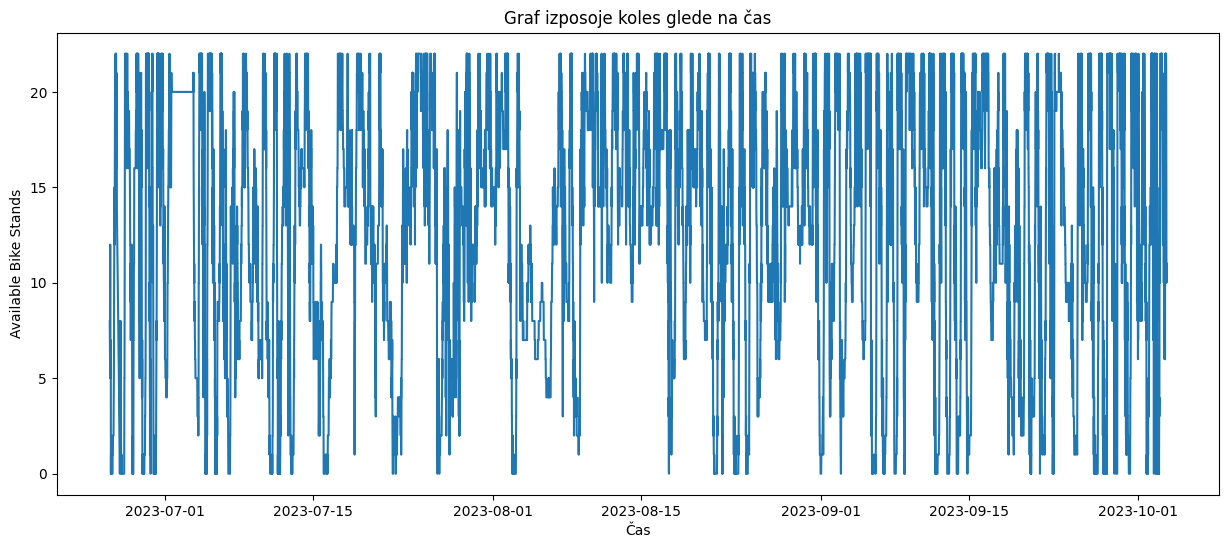

In [53]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['available_bike_stands'])
plt.title('Graf izposoje koles glede na čas')
plt.xlabel('Čas')
plt.ylabel('Available Bike Stands')
plt.show()

In [54]:
# min_values = df.min(axis=0)

# # To get the maximum value of each column
# max_values = df.max(axis=0)

# print("Minimum values of each column:\n", min_values)
# print("\nMaximum values of each column:\n", max_values)

In [55]:
# agregacija podatkov
df.set_index('date', inplace=True)

# Resample the data to hourly intervals and calculate the mean
hourly_data = df.resample('H').mean()

# Reset the index if you want the 'date' column back as a regular column
hourly_data.reset_index(inplace=True)

hourly_data = hourly_data.dropna()

hourly_data

C:\Users\Jaša\AppData\Local\Temp\ipykernel_13612\3888544231.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df.resample('H').mean()


,date,Unnamed: 0,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:00:00+00:00,3.000000,24.425000,43.500000,11.275000,23.650000,0.0,0.0,984.450000,22.0,7.250000
1,2023-06-25 20:00:00+00:00,5.500000,22.850000,49.000000,11.500000,22.500000,0.0,0.0,984.450000,22.0,8.500000
2,2023-06-25 21:00:00+00:00,13.500000,20.950000,56.500000,12.000000,21.050000,0.0,0.0,984.550000,22.0,4.333333
3,2023-06-25 22:00:00+00:00,19.000000,19.520000,65.000000,12.500000,19.450000,0.0,0.0,985.000000,22.0,0.500000
4,2023-06-25 23:00:00+00:00,23.000000,18.000000,73.000000,13.100000,18.300000,0.0,0.0,985.250000,22.0,0.166667
...,...,...,...,...,...,...,...,...,...,...,...
2392,2023-10-03 11:00:00+00:00,18642.727273,19.850000,68.727273,13.781818,20.145455,0.0,0.0,987.909091,22.0,12.363636
2393,2023-10-03 12:00:00+00:00,18654.750000,22.300000,66.000000,15.650000,23.600000,0.0,0.0,987.550000,22.0,16.416667
2394,2023-10-03 13:00:00+00:00,18666.000000,24.272727,63.818182,16.972727,26.127273,0.0,0.0,987.136364,22.0,20.181818
2395,2023-10-03 14:00:00+00:00,18677.500000,25.550000,59.000000,16.950000,27.350000,0.0,0.0,986.600000,22.0,19.416667


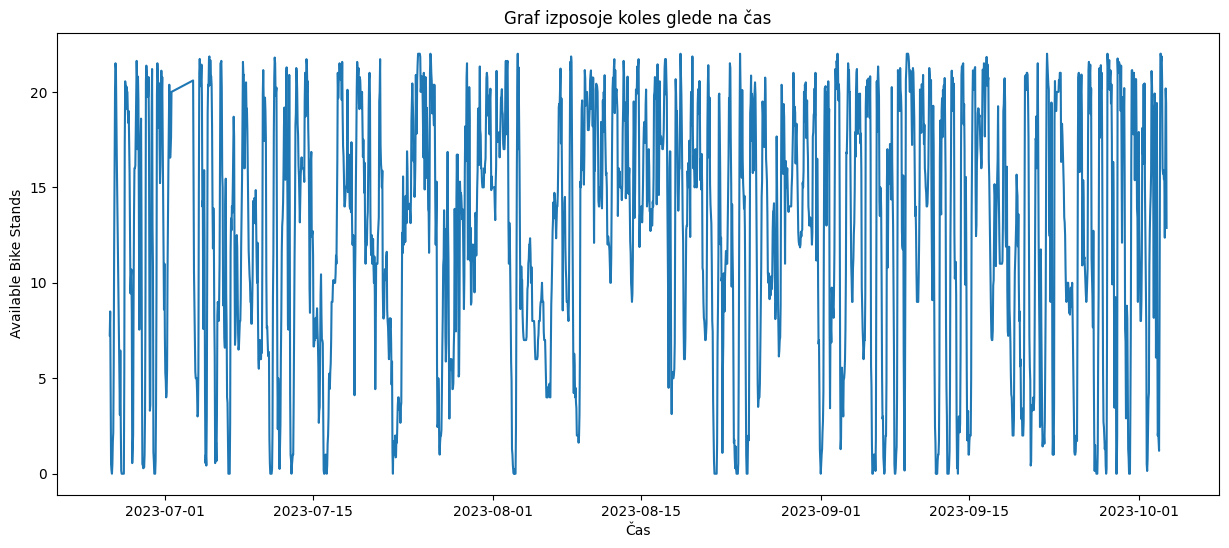

In [56]:
plt.figure(figsize=(15, 6))
plt.plot(hourly_data['date'], hourly_data['available_bike_stands'])
plt.title('Graf izposoje koles glede na čas')
plt.xlabel('Čas')
plt.ylabel('Available Bike Stands')
plt.show()

In [57]:
# filtriramo po available_bike_stands
df_uni = hourly_data['available_bike_stands']
uni_array = df_uni.values.reshape(-1, 1)

# razdelitev na učno in testno množico
train_size = len(df_uni) - 270
train, test = uni_array[0:train_size], uni_array[train_size:]

print('df len', len(df_uni))
print('train len', len(train))
print('test len', len(test))

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

df len 2343
train len 2073
test len 270


In [58]:
def create_dataset(dataset, window_size=45):
  X, y = [], []
  for i in range(len(dataset) - window_size):
      window = dataset[i:i+window_size, 0]
      target = dataset[i+window_size, 0]
      X.append(window)
      y.append(target)
  return np.array(X), np.array(y)

In [59]:
window_size = 45

X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)

print('Oblika učnih podatkov: X_train: ', X_train.shape, ', y_train:', y_train.shape)
print('Oblika testnih podatkov: X_test: ', X_test.shape, ', y_test:', y_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('Preoblikovani X_train:', X_train.shape)
print('Preoblikovani X_test:', X_test.shape)

Oblika učnih podatkov: X_train:  (2028, 45) , y_train: (2028,)
Oblika testnih podatkov: X_test:  (225, 45) , y_test: (225,)
Preoblikovani X_train: (2028, 1, 45)
Preoblikovani X_test: (225, 1, 45)


In [60]:
def build_gru_model(input_shape):
  model = Sequential()
  model.add(GRU(32, activation='relu', input_shape=input_shape, return_sequences=True))
  model.add(GRU(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [61]:
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_gru_model(input_shape)

gru_history = gru_model.fit(X_train, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
51/51 [==============================] - 7s 22ms/step - loss: 0.7439 - val_loss: 0.7433
Epoch 2/15
51/51 [==============================] - 0s 7ms/step - loss: 0.3634 - val_loss: 0.4059
Epoch 3/15
51/51 [==============================] - 0s 7ms/step - loss: 0.2339 - val_loss: 0.3481
Epoch 4/15
51/51 [==============================] - 0s 9ms/step - loss: 0.1816 - val_loss: 0.2623
Epoch 5/15
51/51 [==============================] - 0s 8ms/step - loss: 0.1557 - val_loss: 0.2319
Epoch 6/15
51/51 [==============================] - 0s 7ms/step - loss: 0.1434 - val_loss: 0.2177
Epoch 7/15
51/51 [==============================] - 0s 7ms/step - loss: 0.1274 - val_loss: 0.2128
Epoch 8/15
51/51 [==============================] - 0s 7ms/step - loss: 0.1196 - val_loss: 0.2020
Epoch 9/15
51/51 [==============================] - 0s 7ms/step - loss: 0.1132 - val_loss: 0.1978
Epoch 10/15
51/51 [==============================] - 0s 8ms/step - loss: 0.1060 - val_loss: 0.2015
Epoch 11/15
51/51 

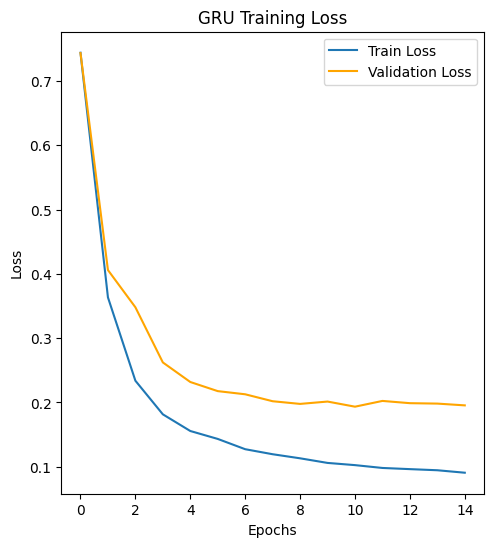

In [62]:
def plot_loss(history, model_name):
  plt.figure(figsize=(12, 6))

  # Plot Training Loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.title(f'{model_name} Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

# Plotting the loss for each model
plot_loss(gru_history, 'GRU')

In [63]:
print(X_test.shape)

# Napovedovanje za vsak model
gru_predictions = gru_model.predict(X_test)
gru_predictions_inv = scaler.inverse_transform(gru_predictions)

print(gru_predictions.shape)
print(y_test.shape)

(225, 1, 45)
8/8 [==============================] - 1s 3ms/step
(225, 1)
(225,)


In [64]:
# Izračun metrik
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

gru_mae = mean_absolute_error(y_test_inv, gru_predictions_inv)
gru_mse = mean_squared_error(y_test_inv, gru_predictions_inv)
gru_evs = explained_variance_score(y_test_inv, gru_predictions_inv)

print("\nGRU Model Metrics:")
print(f"MAE: {gru_mae}, MSE: {gru_mse}, EVS: {gru_evs}")


GRU Model Metrics:
MAE: 2.688693471816696, MSE: 13.610283872774703, EVS: 0.7432644296840558


In [65]:
# shrani model in metrike
gru_history_df = pd.DataFrame(gru_history.history)
gru_history_df.to_csv('../reports/train_metrics.txt', sep='\t', index=False)

gru_test_metrics = pd.DataFrame({
    'mae': [gru_mae],
    'mse': [gru_mse],
    'evs': [gru_evs]
})
gru_test_metrics.to_csv('../reports/test_metrics.txt', sep='\t', index=False)

gru_model.save('../models/uni_gru_model.h5')
joblib.dump(scaler, '../models/uni_gru_scaler.pkl')

['../models/uni_gru_scaler.pkl']